## A. Create Spark Session and Loading the Data
### Step 01: Import Spark Session and Initialize Spark

In [2]:
# import spark session
from pyspark.sql import SparkSession # Spark SQL
from pyspark.sql.functions import *
from pyspark.sql import functions as F

#initialize spark
spark_Session = SparkSession.builder.master("local[4]").appName("mySpark").getOrCreate()


In [3]:
#show the spark session initialized
spark_Session

### Step 02: Load the dataset and print the schema and total number of entries

In [4]:
# read in file
dt = spark_Session.read.csv('weatherAUS.csv', header = True, inferSchema = True)
dt.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



In [5]:
# ptint the number of entries in the dataset
dt.count()

142193

## B. Data Cleaning and Processing
### Step 03: Delete columns from the dataset

In [6]:
# collect column names for columns to be removed
remove_list = ['Date','Location','Evaporation','Sunshine','Cloud9am','Cloud3pm','Temp9am','Temp3pm']

# new dataframe with only required columns
new_dt = dt.select([column for column in dt.columns if column not in remove_list])

new_dt.show(truncate=True)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|       0|        WSW|           46|         W|       WSW|          19|          26|         38|         30|     1007.6|    

### Step 04: Print the number of missing data in each column

In [7]:
# define a function to detect if null value  exist in data 
def find_null(df_in):
    checking = df_in.agg(*[F.count(F.when(F.col(c)=="NA",c)).alias("NA of "+c) for c in df_in.columns])
        
    return checking

In [8]:
# obtain dataframe of nulls 
check_nulls = find_null(new_dt).show()

+-------------+-------------+--------------+-----------------+-------------------+----------------+----------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+---------------+------------------+
|NA of MinTemp|NA of MaxTemp|NA of Rainfall|NA of WindGustDir|NA of WindGustSpeed|NA of WindDir9am|NA of WindDir3pm|NA of WindSpeed9am|NA of WindSpeed3pm|NA of Humidity9am|NA of Humidity3pm|NA of Pressure9am|NA of Pressure3pm|NA of RainToday|NA of RainTomorrow|
+-------------+-------------+--------------+-----------------+-------------------+----------------+----------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+---------------+------------------+
|          637|          322|          1406|             9330|               9270|           10013|            3778|              1348|              2630|             1774|             3610|            14014|      

### Step 05:  Fill the missing data with average value and maximum occurence value

In [9]:
# read in data again and set the null value parameters
dt = spark_Session.read.csv('weatherAUS.csv', header = True, inferSchema = True, nullValue="NA")
new_dt2 = dt.select([column for column in dt.columns if column not in remove_list])
new_dt2.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: integer (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: integer (nullable = true)
 |-- WindSpeed3pm: integer (nullable = true)
 |-- Humidity9am: integer (nullable = true)
 |-- Humidity3pm: integer (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



In [10]:
# select only numeric columns from the dataframe copy
# get row names into a list
str_data = [x[0] for x in new_dt2.dtypes if x[1]=='string']
str_data

['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

In [11]:
# define another function for finding NA
# define a function to detect if null value  exist in data 
def find_null2(df_in):
    checking = df_in.agg(*[F.count(F.when(F.col(c).isNull(),c)).alias(c) for c in df_in.columns])
        
    return checking

In [12]:
# define a function to fill na with mean
def fill_mean(df_in, exclusion=set()):
    
    stat_sel = df_in.agg(*(F.avg(c).alias(c) for c in df_in.columns if c not in exclusion))
    return df_in.na.fill(stat_sel.first().asDict())


In [13]:
# apply the fill na with mean function to the dataframe
new_dt3 = fill_mean(new_dt2,str_data)
# new_dt3.show(1 , vertical = True)

-RECORD 0---------------
 MinTemp       | 13.4   
 MaxTemp       | 22.9   
 Rainfall      | 0.6    
 WindGustDir   | W      
 WindGustSpeed | 44     
 WindDir9am    | W      
 WindDir3pm    | WNW    
 WindSpeed9am  | 20     
 WindSpeed3pm  | 24     
 Humidity9am   | 71     
 Humidity3pm   | 22     
 Pressure9am   | 1007.7 
 Pressure3pm   | 1007.1 
 RainToday     | No     
 RainTomorrow  | No     
only showing top 1 row



In [14]:
# fill data with most frequent data 
for col in str_data:
    #find most frequent count for each column
    fill_group = new_dt3.select(col).groupBy(col).count().orderBy('count',ascending=False)
    # show which column's null is filled
    print(fill_group)
    fill_value = fill_group.select(col).collect()[0][0]
    # show what value is filled for the selected column
    print(fill_value)
    # fill column with dictionary 
    new_dt3 = new_dt3.na.fill({col: fill_value})

DataFrame[WindGustDir: string, count: bigint]
W
DataFrame[WindDir9am: string, count: bigint]
N
DataFrame[WindDir3pm: string, count: bigint]
SE
DataFrame[RainToday: string, count: bigint]
No
DataFrame[RainTomorrow: string, count: bigint]
No


In [15]:
# check nulls again with the check null function
check_dt = find_null2(new_dt3).show(vertical = True)


-RECORD 0------------
 MinTemp       | 0   
 MaxTemp       | 0   
 Rainfall      | 0   
 WindGustDir   | 0   
 WindGustSpeed | 0   
 WindDir9am    | 0   
 WindDir3pm    | 0   
 WindSpeed9am  | 0   
 WindSpeed3pm  | 0   
 Humidity9am   | 0   
 Humidity3pm   | 0   
 Pressure9am   | 0   
 Pressure3pm   | 0   
 RainToday     | 0   
 RainTomorrow  | 0   



### Step 06: Data Transformation

In [17]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import DoubleType

In [18]:
# check data types in dataframe
new_dt3.dtypes

[('MinTemp', 'double'),
 ('MaxTemp', 'double'),
 ('Rainfall', 'double'),
 ('WindGustDir', 'string'),
 ('WindGustSpeed', 'int'),
 ('WindDir9am', 'string'),
 ('WindDir3pm', 'string'),
 ('WindSpeed9am', 'int'),
 ('WindSpeed3pm', 'int'),
 ('Humidity9am', 'int'),
 ('Humidity3pm', 'int'),
 ('Pressure9am', 'double'),
 ('Pressure3pm', 'double'),
 ('RainToday', 'string'),
 ('RainTomorrow', 'string')]

In [19]:
# get list of integer columns
int_data = [x[0] for x in new_dt3.dtypes if x[1]=='int']

In [20]:
# cast integer columns to double 
for colx in int_data: 
    new_dt3 = new_dt3.withColumn(colx, new_dt3[colx].cast(DoubleType()))

In [21]:
# initialise stringindexer
indexers = [StringIndexer(inputCol=cols, outputCol=cols+"Index").fit(new_dt3) for cols in list(str_data)]
# use pipelines to fit the dataframe
pipelines = Pipeline(stages=indexers)
# cast string column to new columns of doubles
trans_dt = pipelines.fit(new_dt3).transform(new_dt3)
# trans_dt.show(vertical=True)


In [22]:
# check data type after casting
trans_dt.printSchema()

root
 |-- MinTemp: double (nullable = false)
 |-- MaxTemp: double (nullable = false)
 |-- Rainfall: double (nullable = false)
 |-- WindGustDir: string (nullable = false)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = false)
 |-- WindDir3pm: string (nullable = false)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = false)
 |-- Pressure3pm: double (nullable = false)
 |-- RainToday: string (nullable = false)
 |-- RainTomorrow: string (nullable = false)
 |-- WindGustDirIndex: double (nullable = false)
 |-- WindDir9amIndex: double (nullable = false)
 |-- WindDir3pmIndex: double (nullable = false)
 |-- RainTodayIndex: double (nullable = false)
 |-- RainTomorrowIndex: double (nullable = false)



### Step 07: Create the feature vector and divide the dataset

In [23]:
# import features from library
from pyspark.ml.feature import VectorAssembler

In [24]:
# obtain the tuple list of dataframe
trans_dt.dtypes

[('MinTemp', 'double'),
 ('MaxTemp', 'double'),
 ('Rainfall', 'double'),
 ('WindGustDir', 'string'),
 ('WindGustSpeed', 'double'),
 ('WindDir9am', 'string'),
 ('WindDir3pm', 'string'),
 ('WindSpeed9am', 'double'),
 ('WindSpeed3pm', 'double'),
 ('Humidity9am', 'double'),
 ('Humidity3pm', 'double'),
 ('Pressure9am', 'double'),
 ('Pressure3pm', 'double'),
 ('RainToday', 'string'),
 ('RainTomorrow', 'string'),
 ('WindGustDirIndex', 'double'),
 ('WindDir9amIndex', 'double'),
 ('WindDir3pmIndex', 'double'),
 ('RainTodayIndex', 'double'),
 ('RainTomorrowIndex', 'double')]

In [25]:
# define the name list of columns to be removed
rm_list = [x[0] for x in trans_dt.dtypes if x[1]=='string']
rm_list

['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

In [26]:
# select the columns for features
vec_df = trans_dt.select([x for x in trans_dt.columns if x not in rm_list])
vec_df.show(3)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+----------------+---------------+---------------+--------------+-----------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDirIndex|WindDir9amIndex|WindDir3pmIndex|RainTodayIndex|RainTomorrowIndex|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+----------------+---------------+---------------+--------------+-----------------+
|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|             0.0|            6.0|            7.0|           0.0|              0.0|
|    7.4|   25.1|     0.0|         44.0|         4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|             9.0|            9.0|            3.0|           0.0|              0.0|
|   12.9|   25.

In [27]:
# select the column names to be featured
vec_cols = vec_df.columns
# exclude RainTomorrowIndex from features
vec_cols.remove('RainTomorrowIndex')

In [28]:
# check the columns to be featurized
vec_cols

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'WindGustDirIndex',
 'WindDir9amIndex',
 'WindDir3pmIndex',
 'RainTodayIndex']

In [29]:
# use VectorAssmbler to genearte vectors
featured = VectorAssembler(inputCols = vec_cols, outputCol = "features")

featured_hash = featured.transform(vec_df)
featured_hash.show(3, truncate=False)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+----------------+---------------+---------------+--------------+-----------------+----------------------------------------------------------------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDirIndex|WindDir9amIndex|WindDir3pmIndex|RainTodayIndex|RainTomorrowIndex|features                                                              |
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+----------------+---------------+---------------+--------------+-----------------+----------------------------------------------------------------------+
|13.4   |22.9   |0.6     |44.0         |20.0        |24.0        |71.0       |22.0       |1007.7     |1007.1     |0.0             |6.0            |7.0            |0.0           |0.0              |

In [30]:
# select feature columns
feature_cols = featured_hash.select(['RainTomorrowIndex', 'features'])
feature_cols.show(3, truncate = False)

+-----------------+----------------------------------------------------------------------+
|RainTomorrowIndex|features                                                              |
+-----------------+----------------------------------------------------------------------+
|0.0              |[13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,0.0,6.0,7.0,0.0]|
|0.0              |[7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,9.0,9.0,3.0,0.0]  |
|0.0              |[12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,6.0,6.0,3.0,0.0]|
+-----------------+----------------------------------------------------------------------+
only showing top 3 rows



In [33]:
# data split with seed set
(train_data, test_data) = feature_cols.randomSplit([0.7,0.3], seed = 2000)
train_data.show(3, truncate = False)

+-----------------+-------------------------------------------------------------------------------------------------------+
|RainTomorrowIndex|features                                                                                               |
+-----------------+-------------------------------------------------------------------------------------------------------+
|0.0              |(14,[0,1,2,3,6,7,8,9],[4.9,19.8,0.1,39.0,81.0,47.0,1017.6537584159615,1015.2582035378894])             |
|0.0              |(14,[0,1,2,3,6,7,8,9],[5.5,19.2,0.2,39.0,93.0,75.0,1017.6537584159615,1015.2582035378894])             |
|0.0              |(14,[0,1,2,3,6,7,8,9],[5.5,23.2267841912725,0.4,39.0,100.0,65.0,1017.6537584159615,1015.2582035378894])|
+-----------------+-------------------------------------------------------------------------------------------------------+
only showing top 3 rows



In the selected column "RainTomorrowIndex", the number 0 and 1 are index of the predicted weather for the next day, where 0 means 'not rain' and 1 means 'rain'. 

## C. Apply Machine Learning Algorithms 

### Step 08: Apply machine learning classification algorithms on the dataset and compare their accuracy. Plot the accuracy as bar graph

In [35]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from matplotlib import pyplot as plt

In [45]:
# define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrowIndex", predictionCol="prediction",\
                                                 metricName="accuracy")

In [46]:
# initialize the input list for y axis to bar chart
count_list = []

####  probability with DecisionTreeClassifier

In [47]:
# Decision Tree Classifier Accuracy
# Initialize the decesiontree classifier
dt_cls = DecisionTreeClassifier(labelCol="RainTomorrowIndex")
dt_models = dt_cls.fit(train_data)
dt_pred = dt_models.transform(test_data)
# get accuracy 
dt_accuracy = evaluator.evaluate(dt_pred)
# add the value to count_list
count_list.append(dt_accuracy)


#### probability with RandomForestClassifier

In [48]:
# Random Forest Classifier Accuracy
# Initialize the Random Forest classifier
rf_cls = RandomForestClassifier(labelCol="RainTomorrowIndex")
rf_models = rf_cls.fit(train_data)
rf_pred = rf_models.transform(test_data)
# get accuracy 
rf_accuracy = evaluator.evaluate(rf_pred)
# add the value to count_list
count_list.append(rf_accuracy)


#### probability with Logistic Regression

In [49]:
# Logistic Regression Classifier Accuracy
# Initialize the Logistic Regression classifier
lr_cls = LogisticRegression(labelCol="RainTomorrowIndex")
lr_models = lr_cls.fit(train_data)
lr_pred = lr_models.transform(test_data)
# get accuracy 
lr_accuracy = evaluator.evaluate(lr_pred)
# add the value to count_list
count_list.append(lr_accuracy)

#### probability with GBTClassifier

In [54]:
# GBT Classifier Accuracy
# Initialize the GBT classifier
gbt_cls = GBTClassifier(labelCol="RainTomorrowIndex")
gbt_models = gbt_cls.fit(train_data)
gbt_pred = gbt_models.transform(test_data)
# get accuracy 
gbt_accuracy = evaluator.evaluate(gbt_pred)
# add the value to count_list
count_list.append(gbt_accuracy)


In [51]:
# show accuracy for all classifiers
count_list

[0.8347401988369911, 0.836147064340649, 0.8382104670793472, 0.8446351528793847]

Text(0.5, 1.0, 'Accuracy of Different Classifiers')

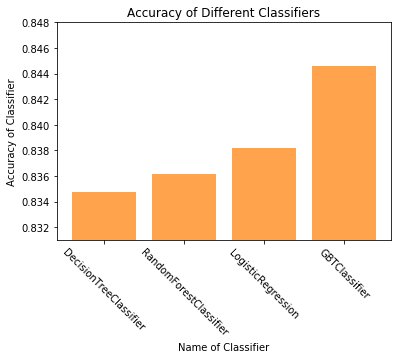

In [52]:
# prepare data for plottiing
class_list = ['DecisionTreeClassifier', 'RandomForestClassifier', 'LogisticRegression', 'GBTClassifier']

# plot data with bar chart
plt.bar(class_list, count_list, color = '#ffa34d')
plt.ylim(0.831, 0.848)
plt.xlabel("Name of Classifier")
plt.xticks(class_list,rotation=-45)
plt.ylabel("Accuracy of Classifier")
plt.title("Accuracy of Different Classifiers")

### Step 09: Calculate confusion matrix and find precision, recall and F1 score for each classification algorithm 

In [55]:
from pyspark.mllib.evaluation import MulticlassMetrics

#### Confusion matrix  and values for Decision Tree

In [56]:
# get values for confusion matrix
dt_cal = dt_pred.rdd.map(lambda x: (x["prediction"], x["RainTomorrowIndex"]))

# calculate confusion matrix
dt_met = MulticlassMetrics(dt_cal)
dt_confMatx = dt_met.confusionMatrix()
# transform the confusion matrix to array
dt_array = dt_confMatx.toArray()
print(dt_array)


[[31816.  1359.]
 [ 5689.  3784.]]


In [59]:
# calculate precision values, recall values, and F1 for decision tree classifier
dt_precision =dt_array[0][0]/(dt_array[0][0]+dt_array[1][0])
print("Precision of Decision Tree Classifier is " + str(dt_precision)+'.')

# calculate recall values
dt_recall = dt_array[0][0]/(dt_array[0][0]+dt_array[0][1])
print("Recall of Decision Tree Classifier is " + str(dt_recall) + '.')

# calculate F1 values
dt_f1 = dt_precision*dt_recall/(dt_precision + dt_recall)*2
print("F1 value of Decision Tree Classifier is " + str(dt_f1) + '.')

Precision of Decision Tree Classifier is 0.8483135581922411.
Recall of Decision Tree Classifier is 0.959035418236624.
F1 value of Decision Tree Classifier is 0.9002829654782117.


#### Confusion matrix and values for Random Forest

In [61]:
# get values for confusion matrix
rf_cal = rf_pred.rdd.map(lambda x: (x["prediction"], x["RainTomorrowIndex"]))

# calculate confusion matrix
rf_met = MulticlassMetrics(rf_cal)
rf_confMatx = rf_met.confusionMatrix()
# transform the confusion matrix to array
rf_array = rf_confMatx.toArray()
print(rf_array)


[[32069.  1106.]
 [ 5882.  3591.]]


In [62]:
# calculate precision values, recall values, and F1 for Random Forest classifier
rf_precision =rf_array[0][0]/(rf_array[0][0]+ rf_array[1][0])
print("Precision of Random Forest Classifier is " + str(rf_precision)+'.')

# calculate recall values
rf_recall = rf_array[0][0]/(rf_array[0][0]+ rf_array[0][1])
print("Recall of Random Forest Classifier is " + str(rf_recall) + '.')

# calculate F1 values
rf_f1 = rf_precision*rf_recall/(rf_precision + rf_recall)*2
print("F1 value of Random Forest Classifier is " + str(rf_f1) + '.')

Precision of Random Forest Classifier is 0.8450106716555559.
Recall of Random Forest Classifier is 0.9666616428033158.
F1 value of Random Forest Classifier is 0.9017518207125383.


#### Confusion matrix and values for Logistic Regression

In [63]:
# get values for confusion matrix
lr_cal = rf_pred.rdd.map(lambda x: (x["prediction"], x["RainTomorrowIndex"]))

# calculate confusion matrix
lr_met = MulticlassMetrics(lr_cal)
lr_confMatx = lr_met.confusionMatrix()
# transform the confusion matrix to array
lr_array = lr_confMatx.toArray()
print(lr_array)

[[32069.  1106.]
 [ 5882.  3591.]]


In [65]:
# calculate precision values, recall values, and F1 for Logistic Regression
lr_precision =lr_array[0][0]/(lr_array[0][0]+ lr_array[1][0])
print("Precision of Logistic Regression is " + str(rf_precision)+'.')

# calculate recall values
lr_recall = lr_array[0][0]/(lr_array[0][0]+ lr_array[0][1])
print("Recall of Logistic Regression is " + str(lr_recall) + '.')

# calculate F1 values
lr_f1 = lr_precision*lr_recall/(lr_precision + lr_recall)*2
print("F1 value of Logistic Regression is " + str(lr_f1) + '.')

Precision of Logistic Regression is 0.8450106716555559.
Recall of Logistic Regression is 0.9666616428033158.
F1 value of Logistic Regression is 0.9017518207125383.


#### Confusion matrix  and values for GBT

In [66]:
# get values for confusion matrix
gbt_cal = gbt_pred.rdd.map(lambda x: (x["prediction"], x["RainTomorrowIndex"]))

# calculate confusion matrix
gbt_met = MulticlassMetrics(gbt_cal)
gbt_confMatx = gbt_met.confusionMatrix()
# transform the confusion matrix to array
gbt_array = gbt_confMatx.toArray()
print(gbt_array)

[[31597.  1578.]
 [ 5048.  4425.]]


In [67]:
# calculate precision values, recall values, and F1 for GBT classifier
gbt_precision =gbt_array[0][0]/(gbt_array[0][0]+ gbt_array[1][0])
print("Precision of GBT Classifier is " + str(gbt_precision)+'.')

# calculate recall values
gbt_recall = gbt_array[0][0]/(gbt_array[0][0]+ gbt_array[0][1])
print("Recall of GBT Classifier is " + str(rf_recall) + '.')

# calculate F1 values
gbt_f1 = gbt_precision*gbt_recall/(gbt_precision + gbt_recall)*2
print("F1 value of GBT Classifier is " + str(gbt_f1) + '.')

Precision of Random Forest Classifier is 0.8622458725610588.
Recall of Random Forest Classifier is 0.9666616428033158.
F1 value of Random Forest Classifier is 0.9050988255514179.


### improve accuracy
A few ways can be used to improve the accuracy of predictions. 

Firstly, more data can be included in sample to give more data to the model be trained with. 

Secondly, the way of filling null values in columns may need some reconsideration. In the process above, the numeric columns are filled with means, which will increase the centralisation of data. Meanwhile, using the most frequent values to fill string columns will lead the result to the extreme by exagerating the most frequent values.

Last but not the least, filter the columns to be featured to help train the models. Some of the features may be noise in data, which can possibly lower the accuracy of prediction 



References:

